In [1]:
# Essential Libraries
import os
import sys
import numpy as np
from numpy import ndarray
import pandas as pd
import datetime
import random
from typing import Callable, Dict, Tuple, List

# ML
# from sklearn import datasets
# import tensorflow as tf
# import keras

# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style("whitegrid");
sns.set_color_codes(palette='pastel');

# Display options
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;
%precision 6

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Define data and image directory
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "img")

from IPython.display import Image
for d in [DATA_DIR, IMAGE_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

# Define a function to save images
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from pprint import pprint

# This is a little recursive helper function converts all nested ndarrays to python list of lists so that pretty printer knows what to do.

def arrayToList(arr):
    if type(arr) == type(np.array):
        #If the passed type is an ndarray then convert it to a list and
        #recursively convert all nested types
        return arrayToList(arr.tolist())
    else:
        #if item isn't an ndarray leave it as is.
        return arr
    
# Suppress exponential notation, define an appropriate float formatter
# Specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:12.4f}'.format}, linewidth=120)

# Boston data

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
data = boston.data
target = boston.target
features = boston.feature_names

# Linear Regression with Gradient Descent

## Data prep

In [5]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=1)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [7]:
X_train.shape, y_train.shape

((354, 13), (354, 1))

## Linear regression  - Custom

In [8]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              )-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]

    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y_batch - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info

In [9]:
def to_2d_np(a: ndarray, 
             type: str = "col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [10]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [11]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)    
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [12]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [13]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss for a step-by-step linear regression
    (used mostly during inference).
    '''
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [14]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [15]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [16]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=1)
losses = train_info[0]
weights = train_info[1]

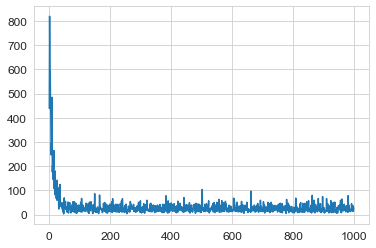

In [17]:
plt.plot(list(range(1000)), losses);

## Model Evaluation

In [18]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [19]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [20]:
preds = predict(X_test, weights)

In [21]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.3846 
Root mean squared error: 4.4974


In [22]:
np.round(y_test.mean(), 4)

22.9822

In [23]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.1957

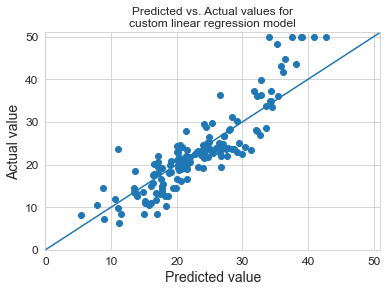

In [24]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

In [25]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

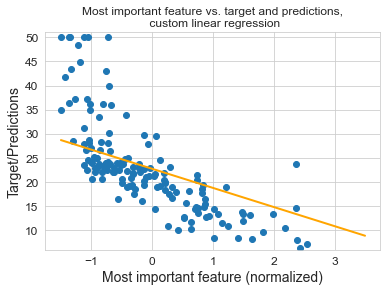

In [26]:
plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n custom linear regression");

## Coefficients

In [27]:
np.round(weights['W'].reshape(-1), 4)

array([     -0.7414,       1.3868,       0.3876,       0.4828,      -2.4510,       2.0392,       0.1126,      -3.2340,
             2.6125,      -1.6812,      -2.1779,       0.6028,      -3.9582])

In [28]:
np.round(weights['B'], 4)

array([[     22.5686]])

# SciKit Learn Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [30]:
import matplotlib.pyplot as plt

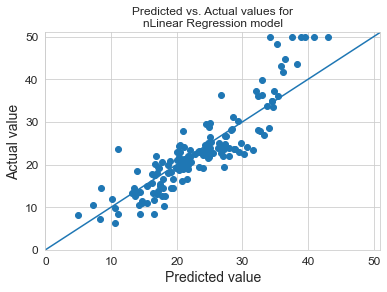

In [31]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nnLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

## Testing changing feature

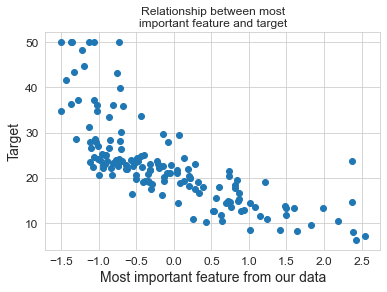

In [32]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target");

## Model Evaluation

In [33]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.3447 
Root mean squared error: 4.4532


In [34]:
import numpy as np
np.round(lr.coef_, 4)

array([[     -0.8468,       1.4162,       0.4055,       0.6190,      -2.4854,       1.9624,       0.1005,
             -3.1897,       2.6752,      -1.8992,      -2.1746,       0.5883,      -4.0581]])

## Coefficients

In [35]:
np.round(weights['W'].reshape(-1), 4)

array([     -0.7414,       1.3868,       0.3876,       0.4828,      -2.4510,       2.0392,       0.1126,      -3.2340,
             2.6125,      -1.6812,      -2.1779,       0.6028,      -3.9582])

In [36]:
np.round(lr.coef_, 4)

array([[     -0.8468,       1.4162,       0.4055,       0.6190,      -2.4854,       1.9624,       0.1005,
             -3.1897,       2.6752,      -1.8992,      -2.1746,       0.5883,      -4.0581]])

In [37]:
np.round(weights['B'], 4)

array([[     22.5686]])

In [38]:
np.round(lr.intercept_, 4)

array([     22.5897])

Coefficients are the same in the SciKit Learn linear regression as in the "custom" linear regression.

## Theoretical relationship between most important feature and target

In [39]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [40]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

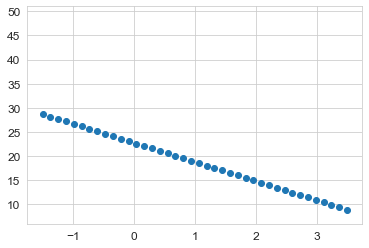

In [41]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51]);

## Regression with a Custom Regressor class

In [42]:
# Define Regressor class
class Regressor():
    # init methodd initializes all parameters needed to implement regression
    def __init__(self, learning_rate=0.01, tol=0.01, seed=None,normalize=False):
        self.W = None
        self.b = None
        self.__lr = learning_rate
        self.__tol = tol
        self.__length = None
        self.__normalize = normalize
        self.__m = None
        self.__costs = []
        self.__iterations = []
        np.random.seed(seed if seed is not None else np.random.randint(100))
    # random initialization of weights and bias
    def __initialize_weights_and_bias(self):
        self.W = np.random.randn(self.__length) #(n,1)
        self.b = 0
    # compute the error function: sum of squared errors 
    def __computeCost(self,h,Y):
        loss = np.square(h-Y)
        cost = np.sum(loss)/(2*self.__m)
        return cost
    # implement optimization function
    def __optimize(self,X,Y):
        h = np.dot(X,self.W)+self.b
        dW = np.dot( X.T, (h-Y) ) / self.__m
        db = np.sum( h-Y )  / self.__m
        self.W = self.W - self.__lr*dW
        self.b = self.b - self.__lr*db
    # normalize the dataset by subtracting the mean and dividing by std deviation
    def __normalizeX(self,X):return (X-self.__mean) / (self.__std)
    # fit the model to the dataset: training process
    def fit(self, X, y, verbose=False):
        if self.__normalize:
            self.__mean, self.__std = X.mean(axis=0), X.std(axis=0)
            X = self.__normalizeX(X)
        self.__m,self.__length = X.shape
        self.__initialize_weights_and_bias()
        last_cost,i = float('inf'),0
        while True:
            h = np.dot(X,self.W)+self.b
            cost = self.__computeCost(h,y)
            if verbose: print(f"Iteration: {i}, Cost: {cost:.3f}")
            self.__optimize(X,y)
            if last_cost-cost < self.__tol: break
            else: last_cost,i = cost,i+1
            self.__costs.append(cost)
            self.__iterations.append(i)
    # test the model on test data
    def predict(self,X):

        if self.__normalize: X = self.__normalizeX(X)
        return np.dot(X,self.W)+self.b
    # plot the iterations vs cost curves
    def plot(self,figsize=(7,5)):
        plt.figure(figsize=figsize)
        plt.plot(self.__iterations,self.__costs)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title("Iterations vs Cost")
        plt.show()
    # calculates the accuracy
    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))

In [43]:
data = load_boston()
# split the dataset into train and test sets
X_train, X_test, y_train,y_test = train_test_split(data.data, data.target,test_size=0.2)

Train Score: 0.6947404646173694
Test Score:  0.7852917979153783


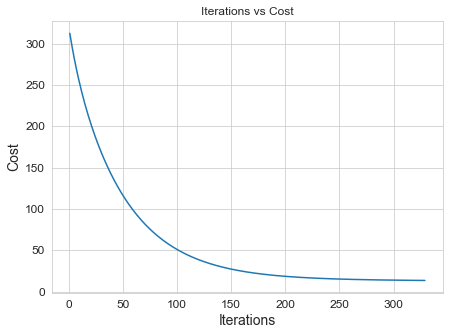

In [44]:
regressor = Regressor(normalize=True)
# call the fit method
regressor.fit(X_train,y_train)

train_score = regressor.score(X_train,y_train)
test_score = regressor.score(X_test,y_test)

print("Train Score:", train_score)
print("Test Score: ",test_score)
regressor.plot()

In [45]:
regressor.W

array([     -0.4898,       0.2683,      -0.9395,       0.9603,      -0.6896,       3.3642,      -0.2795,      -1.8207,
            -0.4110,       0.8112,      -1.7207,       0.7307,      -3.2731])

In [46]:
preds = regressor.predict(X_test)

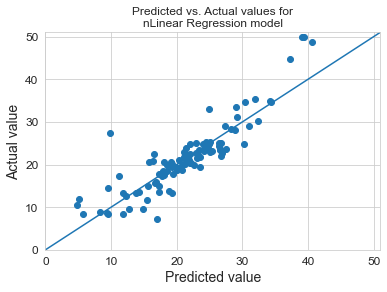

In [47]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nnLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

# Neural Network Regression

## Boston data

In [48]:
from sklearn.datasets import load_boston

In [49]:
boston = load_boston()

In [50]:
data = boston.data
target = boston.target
features = boston.feature_names

## Data prep

In [51]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=1)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [53]:
X_train.shape, y_train.shape

((354, 13), (354, 1))

## Activation Function

In [54]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

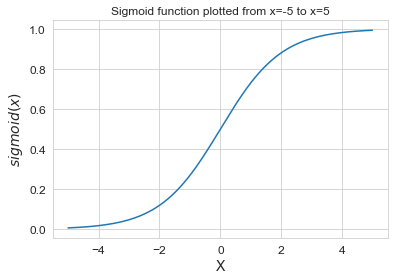

In [55]:
plt.plot(np.arange(-5, 5, 0.01),
         sigmoid(np.arange(-5, 5, 0.01)));
plt.title("Sigmoid function plotted from x=-5 to x=5")
plt.xlabel("X")
plt.ylabel("$sigmoid(x)$");

In [56]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    '''
    Initialize weights during the forward pass for step-by-step neural network model.
    '''
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [57]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    '''
    Compute the forward pass and the loss for the step-by-step 
    neural network model.     
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [58]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute the partial derivatives of the loss with respect to each of the parameters in the neural network.
    '''    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = np.ones_like(weights['B2'])

    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)

    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdW1 = np.dot(dM1dW1, dLdM1)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

In [59]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]) -> ndarray:
    '''
    Generate predictions from the step-by-step neural network model. 
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [60]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)

    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [61]:
TEST_ALL = False

In [62]:
if TEST_ALL:
    num_iter = 10000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [63]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

### Learning rate tuning

In [64]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = learning_rate,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return r2_score(y_test, preds)

In [65]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [66]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [67]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

## Evaluating best model

In [68]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

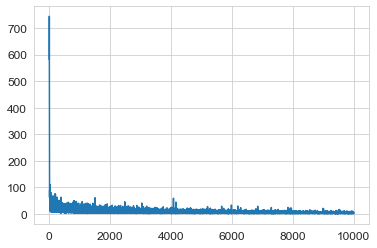

In [69]:
plt.plot(list(range(10000)), losses);

In [70]:
preds = predict(X_test, weights)

## Investigation of most important features

Most important combinations of features are the two with absolute values of greater than 9:

In [71]:
weights['W2']

array([[      5.1388],
       [      6.9679],
       [      7.5408],
       [      6.5370],
       [      9.1625],
       [      6.3093],
       [      2.8893],
       [     11.2383],
       [      7.3012],
       [     -9.5124],
       [      6.8687],
       [      3.9764],
       [     -6.4232]])

These are at index 7 and index 9. Here are the combinations themselves:

In [72]:
weights['W1'][7]

array([      1.7517,      -0.0386,       2.9291,      -4.0072,       2.2443,      -3.0097,      -0.6494,      -3.1674,
             0.1112,      -0.0922,      -2.0710,       0.1170,       0.9386])

In [73]:
weights['W1'][9]

array([     -2.8750,       2.5023,       1.6532,      -2.1180,      -0.7239,       2.2670,       0.8305,       0.4533,
            -2.8541,      -1.4478,      -3.6359,       1.0891,       1.1695])

In [74]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 2.4336 
Root mean squared error: 3.2503


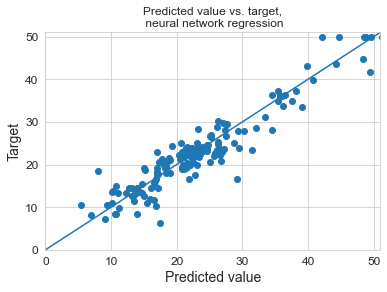

In [75]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target,\n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

In [76]:
np.round(np.mean(np.array(np.abs(preds - y_test))), 4)

2.4336

In [77]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

10.5643

## Theoretical relationship between most important feature and target

In [78]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

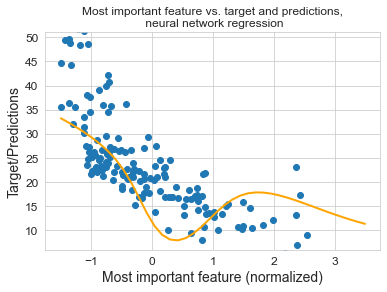

In [79]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n neural network regression");